In [1]:
%matplotlib inline 

# Caching Rest Data Investigation
***

## Table of Contents
***

## Aim <a class="anchor" id="aim"></a>
***

The aim of this notebook is to do some Exploratory data analysis on the data obtained from the Caching Rest Application

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Import Libraries

In [2]:
import pymysql
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = 14, 8
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Custom Classes

In [3]:
class CachePerformanceMetric:
    def __init__(self, cache_hit_size, cache_miss_size):
        self.cache_hit_size = cache_hit_size
        self.cache_miss_size = cache_miss_size
        self.total_size = cache_hit_size + cache_miss_size
        self.hit_ratio = cache_hit_size/self.total_size
    
    def __repr__(self):
        return "Hit Ratio : " + str(self.hit_ratio)

class MainCacheAnalyseData:
    def __init__(self, batch_ids, cache_performance_metrics, cache_initial_content_per_batch,
                cache_performance_per_batch, cache_remainder_per_batch, agg_df):
        self.batch_ids = batch_ids
        self.cache_performance_metrics = cache_performance_metrics
        self.cache_initial_content_per_batch = cache_initial_content_per_batch
        self.cache_performance_per_batch = cache_performance_per_batch
        self.cache_remainder_per_batch = cache_remainder_per_batch
        self.agg_df = agg_df
    def __iter__(self):
        yield 'batch_ids', self.batch_ids
        yield 'cache_performance_metrics', self.cache_performance_metrics
        yield 'cache_initial_content_per_batch', self.cache_initial_content_per_batch
        yield 'cache_performance_per_batch', self.cache_performance_per_batch
        yield 'cache_remainder_per_batch', self.cache_remainder_per_batch
        yield 'agg_df', self.agg_df

### Constants

In [4]:
db_connection = pymysql.connect("pidb","dbuser","password","cachetest" )

### Useful Functions

#### Table Read

In [5]:
def read_full_db_table(table_name):
    return pd.read_sql('SELECT * FROM ' + table_name, con=db_connection)

#### Query to Dataframe

In [6]:
def obtain_df_from_query(query_string):
    return pd.read_sql(query_string, con=db_connection)

#### Cache Hit Bytes to Boolean

In [7]:
def convert_cache_hit_to_boolean(df):
    df.cache_hit = df.cache_hit.map({b'\x00' : False, b'\x01' : True})
    return df

#### DF ids to comma seperated string

In [8]:
def df_ids_to_string(df):
    id_list = df.id.tolist()
    id_list = [str(i) for i in id_list]
    return ''.join(id_list)

#### Compute Average Hit Ratio

In [9]:
def compute_average_hit_ratio(agg_df):
    average_hit_ratio = 0
    hit_ratio_list = agg_df.hit_ratio.tolist()
    for hit_ratio in hit_ratio_list:
        average_hit_ratio = average_hit_ratio + hit_ratio
    average_hit_ratio = average_hit_ratio/(len(hit_ratio_list))
    return average_hit_ratio

#### Compute Cache Size from Dataframe

In [10]:
def cache_size_mb_from_cache_content(df):
    return (df[["file_sizekb"]].sum().values[0])/1024

#### Process a Set of Parameters

In [11]:
def crunch_the_data(cache_type, cache_size_mb, eviction_policy):
    query_for_batch = ("cache_type == '" + cache_type + "' and cache_size_mb == '" + str(cache_size_mb) 
                       + "' and eviction_policy == '" + eviction_policy + "'")
    # Batches fitting criteria
    batches_df = batch_df.query(query_for_batch)
    
    if(batches_df.empty):
        print("Sorry, No batches for :", cache_type, ",", cache_size_mb, ",",  eviction_policy)
        return None
    
    # Cache Performance
    cache_performace_df = obtain_df_from_query("SELECT * FROM cache_performance cp where cp.batch_id in ("
                                              + df_ids_to_string(batches_df)
                                              + ")")
    # Issue with Booleans coming in as bytes and not booleans
    cache_performace_df = convert_cache_hit_to_boolean(cache_performace_df)
    
    # Cache Initial Content
    cache_initial_content_df = obtain_df_from_query("SELECT * FROM cache_initial_content cic where cic.batch_id in ("
                                              + df_ids_to_string(batches_df)
                                              + ")")
    # Cache Remainder
    cache_remainder_df = obtain_df_from_query("SELECT * FROM cache_remainder cr where cr.batch_id in ("
                                              + df_ids_to_string(batches_df)
                                              + ")")

    # Separate data into dictionary based on batches
    cache_performance_per_batch = {}
    cache_initial_content_per_batch = {}
    cache_remainder_per_batch = {}
    batch_ids = batches_df.id.unique().tolist()
    for batch_id in batch_ids :
        query_for_df = "batch_id == '" + str(batch_id) + "'"
        cache_performance_per_batch[batch_id] = cache_performace_df.query(query_for_df)
        cache_initial_content_per_batch[batch_id] = cache_initial_content_df.query(query_for_df)
        cache_remainder_per_batch[batch_id] = cache_remainder_df.query(query_for_df)
    
    # Compute the Cache Performance Metrics
    cache_performance_metrics = []
    cache_size_mb_initial_list = []
    element_count_at_start_list = []
    element_count_testing_list = []
    number_of_hits_list = []
    number_of_misses_list = []
    hit_ratio_list = []
    cache_size_mb_end_list = []
    element_count_at_end_list = []
    
    for batch_id in batch_ids :
        cp_df = cache_performance_per_batch[batch_id]
        cic_df = cache_initial_content_per_batch[batch_id]
        cr_df = cache_remainder_per_batch[batch_id]
        
        # Cache MB in Cache at Start
        initial_full_cache_size_mb = cache_size_mb_from_cache_content(cic_df)
        element_count_at_start = cic_df.shape[0]
        
        element_count_testing = cp_df.shape[0]
        # Calculate Hit Ratio
        cp_df_hit = cp_df.query("cache_hit")
        cp_df_miss = cp_df.query("cache_hit == False")
        hit_size = cp_df_hit.shape[0]
        miss_size = cp_df_miss.shape[0]
        cache_performance_metric = CachePerformanceMetric(hit_size, miss_size)
        cache_performance_metrics.append(cache_performance_metric)
        
        # Cache MB in Cache at End
        end_full_cache_size_mb = cache_size_mb_from_cache_content(cr_df)
        element_count_at_end = cr_df.shape[0]
        
        # Add Aggregate Data to lists
        cache_size_mb_initial_list.append(initial_full_cache_size_mb)
        element_count_at_start_list.append(element_count_at_start)
        element_count_testing_list.append(element_count_testing)
        number_of_hits_list.append(hit_size)
        number_of_misses_list.append(miss_size)
        hit_ratio_list.append(cache_performance_metric.hit_ratio)
        cache_size_mb_end_list.append(end_full_cache_size_mb)
        element_count_at_end_list.append(element_count_at_end)
   
    # Gen Aggregate Data DF
    agg_data = {"batch_id": batch_ids, 
                "cache_size_mb_initial" : cache_size_mb_initial_list,
                "element_count_at_start" : element_count_at_start_list,
                "element_count_testing" : element_count_testing_list,
                "number_of_hits" : number_of_hits_list,
                "number_of_misses" : number_of_misses_list,
                "hit_ratio" : hit_ratio_list,
                "cache_size_mb_end" : cache_size_mb_end_list,
                "element_count_at_end" : element_count_at_end_list
                }
    agg_df = pd.DataFrame(data=agg_data)
     
    # Average Hit Ratio
    average_hit_ratio = compute_average_hit_ratio(agg_df)
    print("Average Hit Ratio :", average_hit_ratio)
    
    # Generate the important data made from this incase it is needed elsewhere
    main_analyse_data = MainCacheAnalyseData(batch_ids, cache_performance_metrics, cache_initial_content_per_batch,
                                            cache_performance_per_batch, cache_remainder_per_batch, agg_df)
    
    # Tried being smart but dictionary was just easiest way to go
    return dict(main_analyse_data)

#### Obtain Batch Info from Id

In [12]:
def obtain_batch_info(batch_id):
    batch_info = batch_df.query("id == " + str(batch_id))
    return batch_info

#### Plot Avg Hit Ratio

In [13]:
def plot_avg_hit_ratio(graph_title, *cache_analyse_data):
    if(len(cache_analyse_data) <= 0):
        print("Can't plot what I don't have")
        return
    cache_list = []
    avg_hit_ratio_list = []
    # Going to assume that all batch ids of main data analyse point to same cache type
    for main_cache_analyse_data in  cache_analyse_data:
        batch_info = obtain_batch_info(main_cache_analyse_data["batch_ids"][0])
        avg_hit_ratio = compute_average_hit_ratio(main_cache_analyse_data["agg_df"])
        cache_type = batch_info.cache_type.tolist()[0]
        cache_size = batch_info.cache_size_mb.tolist()[0]
        eviction_policy = batch_info.eviction_policy.tolist()[0]
        cache_list.append(cache_type + "-" + str(cache_size) + "MB-" + eviction_policy)
        avg_hit_ratio_list.append(avg_hit_ratio)
    
    d = {"cache": cache_list, "avg_hit_ratio" : avg_hit_ratio_list}
    df = pd.DataFrame(data=d)
    fig, ax = plt.subplots()

    df['avg_hit_ratio'].plot.bar()

    ax.set_xticklabels(df["cache"], rotation='vertical')
    plt.xlabel('Cache Type')
    plt.ylabel('Avg Hit Ratio')
    plt.title(graph_title)
    plt.show()

#### Plot Cache Size vs Hit Ratio For a Single Cache Type and Replacement Algorithm

In [14]:
def plot_cache_size_vs_avg_hit_ratio(*cache_analyse_data):
    if(len(cache_analyse_data) <= 0):
        print("Can't plot what I don't have")
        return
    cache_list = []
    eviction_policy_list = []
    cache_size_list = []
    avg_hit_ratio_list = []
    # Going to assume that all batch ids of main data analyse point to same cache type and size
    # Also going to assume that all analyse data fed into this method belong to same cache type and eviction policy
    for main_cache_analyse_data in  cache_analyse_data:
        batch_info = obtain_batch_info(main_cache_analyse_data["batch_ids"][0])
        avg_hit_ratio = compute_average_hit_ratio(main_cache_analyse_data["agg_df"])
        cache_type = batch_info.cache_type.tolist()[0]
        cache_size = batch_info.cache_size_mb.tolist()[0]
        eviction_policy = batch_info.eviction_policy.tolist()[0]
        
        cache_list.append(cache_type)
        eviction_policy_list.append(eviction_policy)
        cache_size_list.append(int(cache_size))
        avg_hit_ratio_list.append(avg_hit_ratio)
        
    
    if(len(set(cache_list)) != 1) or (len(set(eviction_policy_list)) != 1):
        print("The cache type and eviction policy must be constant to use this function only cache size may change")
        return
    
    fig, ax = plt.subplots()
    
    title = "Avg Hit Ratio vs Cache size for " + cache_list[0] + " " + eviction_policy_list[0]
    d = {"cache_size": cache_size_list, "avg_hit_ratio" : avg_hit_ratio_list}
    df = pd.DataFrame(data=d)
    df = df.sort_values(by=["cache_size"], ascending=True)
                                      
    plt.plot(df["cache_size"], df["avg_hit_ratio"], "-o")
    plt.xlabel('Cache Size (MB)')
    plt.ylabel('Avg Hit Ratio')
    plt.title(title)
    plt.show()

#### Plot Cache Size vs Hit Ratio For Multiple Caches

In [38]:
def plot_cache_size_vs_avg_hit_ratio_multiple(*cache_analyse_data_list):
    if(len(cache_analyse_data_list) <= 0):
        print("Can't plot what I don't have")
        return
    
    legend=[]
    fig, ax = plt.subplots()
    for cache_analyse_data in cache_analyse_data_list:
        cache_list = []
        eviction_policy_list = []
        cache_size_list = []
        avg_hit_ratio_list = []
        # Going to assume that all batch ids of main data analyse point to same cache type and size
        # Also going to assume that all analyse data fed into this method belong to same cache type and eviction policy
        for main_cache_analyse_data in  cache_analyse_data:
            batch_info = obtain_batch_info(main_cache_analyse_data["batch_ids"][0])
            avg_hit_ratio = compute_average_hit_ratio(main_cache_analyse_data["agg_df"])
            cache_type = batch_info.cache_type.tolist()[0]
            cache_size = batch_info.cache_size_mb.tolist()[0]
            eviction_policy = batch_info.eviction_policy.tolist()[0]

            cache_list.append(cache_type)
            eviction_policy_list.append(eviction_policy)
            cache_size_list.append(int(cache_size))
            avg_hit_ratio_list.append(avg_hit_ratio)

        if(len(set(cache_list)) != 1) or (len(set(eviction_policy_list)) != 1):
            print("The cache type and eviction policy must be constant to use this function only cache size may change")
            return

        d = {"cache_size": cache_size_list, "avg_hit_ratio" : avg_hit_ratio_list}
        df = pd.DataFrame(data=d)
        df = df.sort_values(by=["cache_size"], ascending=True)

        plt.plot(df["cache_size"], df["avg_hit_ratio"], "-o")
        legend.append(cache_list[0] + " - " + eviction_policy_list[0])
        
    plt.xlabel('Cache Size (MB)')
    plt.ylabel('Avg Hit Ratio')
    plt.title("Avg Hit Ratio vs Cache size")
    lg = plt.legend(legend, frameon=True)
    lg.get_frame().set_facecolor('white')
    plt.show()

### Global Data

In [16]:
batch_df = read_full_db_table("batch")

## Ehcache Data

### Ehcache LRU 128 MB

In [17]:
ehcache_lru_128_data = crunch_the_data("ehcache", 128, "LRU")
ehcache_lru_128_data["agg_df"]

Average Hit Ratio : 0.06337195554504611


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,3,127.076172,127.24707,918,769,4229,0.063372,268,3961


### Ehcache LRU 256 MB

In [18]:
ehcache_lru_256_data = crunch_the_data("ehcache", 256, "LRU")
ehcache_lru_256_data["agg_df"]

Average Hit Ratio : 0.12517321016166283


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,1,254.306641,254.633789,1795,1480,8660,0.125173,1084,7576


### Ehcache LRU 512 MB

In [19]:
ehcache_lru_512_data = crunch_the_data("ehcache", 512, "LRU")
ehcache_lru_512_data["agg_df"]

Average Hit Ratio : 0.25092608183195825


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,2,508.772461,509.032227,3777,3525,23756,0.250926,5961,17795


### Ehcache LRU 1024 MB

In [20]:
ehcache_lru_1024_data = crunch_the_data("ehcache", 1024, "LRU")
ehcache_lru_1024_data["agg_df"]

Average Hit Ratio : 0.5062229213235091


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,4,1017.924805,1017.93457,7578,7245,72474,0.506223,36688,35786


## Hazelcast Data

### Hazelcast LRU 128 MB

In [21]:
hazelcast_lru_128_data = crunch_the_data("hazelcast", 128, "LRU")
hazelcast_lru_128_data["agg_df"]

Average Hit Ratio : 0.05719071548217277


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,8,132.353516,127.71875,875,772,4179,0.057191,239,3940


### Hazelcast LRU 256 MB

In [22]:
hazelcast_lru_256_data = crunch_the_data("hazelcast", 256, "LRU")
hazelcast_lru_256_data["agg_df"]

Average Hit Ratio : 0.1005811884711185


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,7,262.19043,254.733398,1629,1484,8431,0.100581,848,7583


### Hazelcast LRU 512 MB

In [23]:
hazelcast_lru_512_data = crunch_the_data("hazelcast", 512, "LRU")
hazelcast_lru_512_data["agg_df"]

Average Hit Ratio : 0.24765486351728216


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,5,515.367188,509.485352,3736,3529,23666,0.247655,5861,17805


### Hazelcast LRU 1024 MB

In [24]:
hazelcast_lru_1024_data = crunch_the_data("hazelcast", 1024, "LRU")
hazelcast_lru_1024_data["agg_df"]

Average Hit Ratio : 0.49796682191048386


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,6,1031.755859,1018.132812,7517,7244,71071,0.497967,35391,35680


## Redis Data

### Redis LRU 128 MB

In [25]:
redis_lru_128_data = crunch_the_data("redis", 128, "LRU")
redis_lru_128_data["agg_df"]

Average Hit Ratio : 0.05128205128205128


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,14,114.624023,114.500977,875,699,4134,0.051282,212,3922


### Redis LRU 256 MB

In [26]:
#redis_lru_256_data = crunch_the_data("redis", 256, "LRU")
#redis_lru_256_data["agg_df"]

### Redis LRU 512 MB

In [27]:
#redis_lru_512_data = crunch_the_data("redis", 512, "LRU")
#redis_lru_512_data["agg_df"]

### Redis LRU 1024 MB

In [28]:
redis_lru_1024_data = crunch_the_data("redis", 1024, "LRU")
redis_lru_1024_data["agg_df"]

Average Hit Ratio : 0.45499785631163103


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,15,927.371094,927.032227,6841,6715,65308,0.454998,29715,35593


## Memcached Data

### Memcached LRU 128 MB

In [29]:
memcached_lru_128_data = crunch_the_data("memcached", 128, "LRU")
memcached_lru_128_data["agg_df"]

Average Hit Ratio : 0.05735541156707463


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,13,112.394531,110.03125,973,692,4167,0.057355,239,3928


### Memcached LRU 256 MB

In [30]:
memcached_lru_256_data = crunch_the_data("memcached", 256, "LRU")
memcached_lru_256_data["agg_df"]

Average Hit Ratio : 0.10471820214142841


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,12,230.811523,224.958984,1702,1368,8499,0.104718,890,7609


### Memcached LRU 512 MB

In [31]:
memcached_lru_512_data = crunch_the_data("memcached", 512, "LRU")
memcached_lru_512_data["agg_df"]

Average Hit Ratio : 0.2355234094157391


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,10,460.295898,454.220703,3589,3274,23089,0.235523,5438,17651


### Memcached LRU 1024 MB

In [32]:
memcached_lru_1024_data = crunch_the_data("memcached", 1024, "LRU")
memcached_lru_1024_data["agg_df"]

Average Hit Ratio : 0.44759977133322004


,batch_id,cache_size_mb_end,cache_size_mb_initial,element_count_at_end,element_count_at_start,element_count_testing,hit_ratio,number_of_hits,number_of_misses
0,11,922.816406,921.205078,6740,6593,64723,0.4476,28970,35753


## 128 MB LRU Comparison

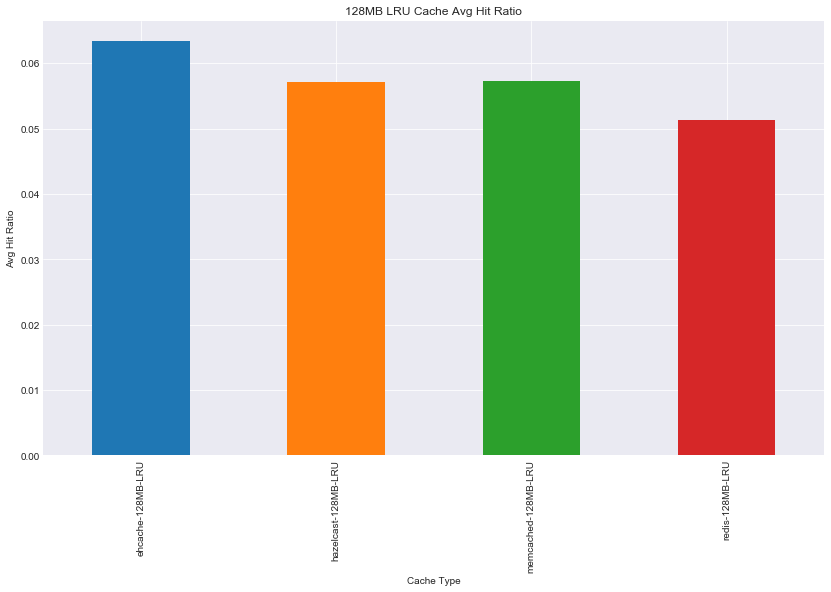

In [33]:
plot_avg_hit_ratio("128MB LRU Cache Avg Hit Ratio", 
                    ehcache_lru_128_data, 
                    hazelcast_lru_128_data, 
                    memcached_lru_128_data,
                    redis_lru_128_data
                  )

## 256 MB LRU Comparison

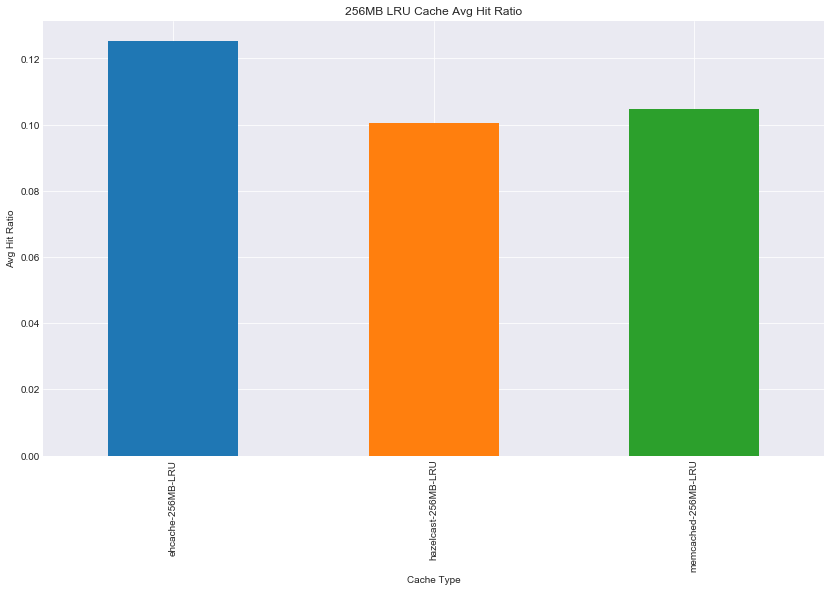

In [34]:
plot_avg_hit_ratio("256MB LRU Cache Avg Hit Ratio", 
                    ehcache_lru_256_data, 
                    hazelcast_lru_256_data, 
                    memcached_lru_256_data
                  )

## 512 MB LRU Comparison

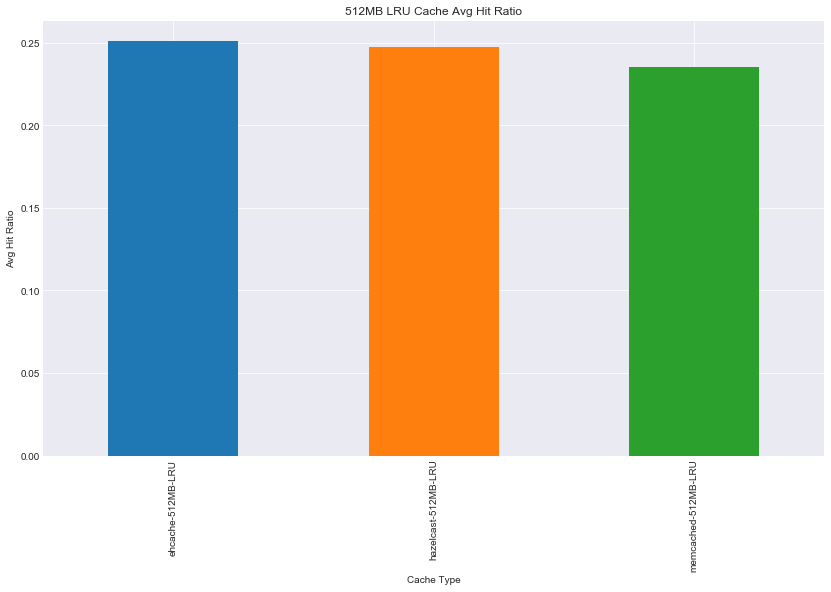

In [35]:
plot_avg_hit_ratio("512MB LRU Cache Avg Hit Ratio", 
                    ehcache_lru_512_data, 
                    hazelcast_lru_512_data, 
                    memcached_lru_512_data
                  )

## 1024 MB LRU Comparison

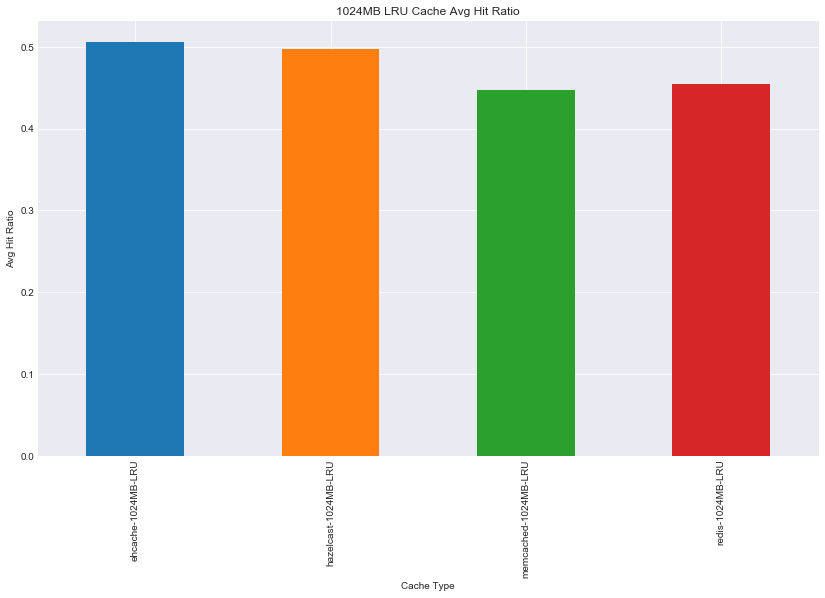

In [36]:
plot_avg_hit_ratio("1024MB LRU Cache Avg Hit Ratio", 
                    ehcache_lru_1024_data, 
                    hazelcast_lru_1024_data,
                    memcached_lru_1024_data,
                    redis_lru_1024_data
                  )

## Cache Size vs Avg Hit Ratio

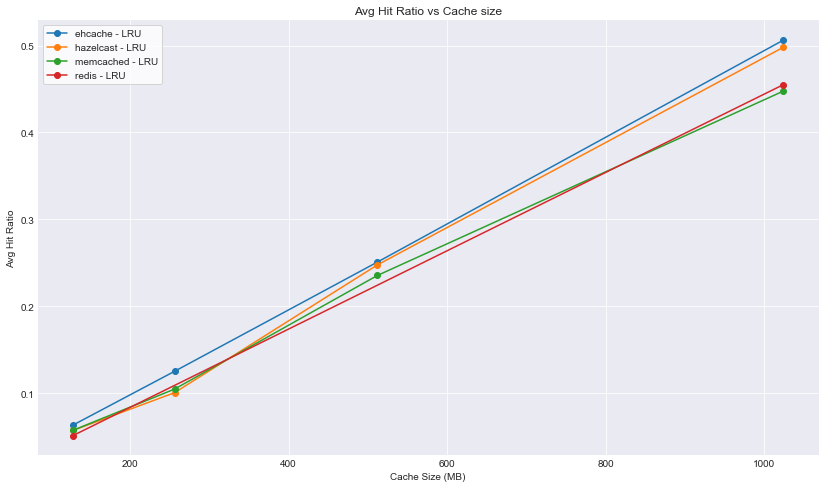

In [39]:
ehcache_list = [ehcache_lru_1024_data,
                   ehcache_lru_512_data,
                   ehcache_lru_256_data,
                   ehcache_lru_128_data
               ]
hazelcast_list = [hazelcast_lru_1024_data,
                   hazelcast_lru_512_data,
                   hazelcast_lru_256_data,
                   hazelcast_lru_128_data
                 ]
memcached_list = [memcached_lru_1024_data,
                   memcached_lru_512_data,
                   memcached_lru_256_data,
                   memcached_lru_128_data
                 ]
redis_list = [redis_lru_1024_data, 
              redis_lru_128_data
             ]
plot_cache_size_vs_avg_hit_ratio_multiple(ehcache_list, hazelcast_list, memcached_list, redis_list)